### Building NGC graphs

Construct Graph\
\
<img src="Group42.png" alt="MarineGEO circle logo" style="height: 200px; width:100px;"/>




In [1]:
from construction_utils import SNodeBuilder, CableConnector
from ngclearn.engine.ngc_graph import NGCGraph
from ngclearn.engine.nodes.enode import ENode


In [2]:
dim = 4
bd = SNodeBuilder()
cc = CableConnector()

a = bd.O1_set_numerals(beta=1.0, leak=0.0, zeta=0.0).O0_build(name="a", dim=dim, reset=False)
b = bd.O0_build(name="b", dim=dim)

a_b = cc.O1_dense().Op1_with_update_rule(a, b).Op2_with_constraints().O0_connect(a, b)

model = NGCGraph(K=1)
model.set_cycle([a, b])
model.apply_constraints()
comp = model.compile(batch_size=1)

Connecting nodes a-b with -dense- cable


In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
opt = tf.optimizers.SGD(learning_rate=0.1)


In [4]:
import numpy as np
import time
import matplotlib.pyplot as plt
from IPython.display import display, clear_output


# figure, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(5, 8))
# bc1 = ax1.bar(list(range(dim)), np.linspace(-2,2,dim))
# bc3 = ax3.bar(list(range(dim)), np.linspace(-2,2,dim))
# bc2 = ax2.matshow(model.theta[0].numpy(), cmap='seismic', vmin=-1.0, vmax=1.0)
# ax1.set_title("z of a", fontsize=10)
# ax3.set_title("z of b", fontsize=10)

# ones = tf.ones([1, dim])
# plt.ion()
# for i in range(20):
#     readouts = model.settle(
#         clamped_vars=[("a", "z", ones)],
#         readout_vars=[("a", "z"),("b", "z")]
#     )
#     delta = model.calc_updates()
#     # print("The value of {} w/in Node {} is {}".format(readouts[0][0][1], readouts[0][0][0], readouts[0][0][2].numpy()))
#     opt.apply_gradients(zip(delta, model.theta))
#     model.apply_constraints()
#     for d in range(dim):
#         bc1[d].set_height((readouts[0][0][2].numpy()[0][d]))
#         bc3[d].set_height((readouts[0][1][2].numpy()[0][d]))
#     bc2.set_data(model.theta[0].numpy())
#     model.clear()

#     clear_output(wait=True)
#     figure.canvas.draw()
#     display(figure)
#     time.sleep(0.1)

# Learning a Data Generating Process


In [5]:
from ngclearn.generator.static.mog import MoG

In [6]:
mu1 = np.array([[-1.0,1.2]])
cov1 = np.array([[0.1,0.0],
                 [0.0,0.2]])
mu1 = tf.cast(mu1,dtype=tf.float32)
cov1 = tf.cast(cov1,dtype=tf.float32)

mu2 = np.array([[0.85,-1.3]])
cov2 = np.array([[0.2,0.0],
                 [0.0,0.12]])
mu2 = tf.cast(mu2,dtype=tf.float32)
cov2 = tf.cast(cov2,dtype=tf.float32)

mu3 = np.array([[0.92, 1.1]])
cov3 = np.array([[0.12,0.0],
                 [0.0,0.18]])
mu3 = tf.cast(mu3,dtype=tf.float32)
cov3 = tf.cast(cov3,dtype=tf.float32)


In [7]:
mu_list = [mu1, mu2, mu3]
sigma_list = [cov1, cov2, cov3]
process = MoG(means=mu_list, covar=sigma_list, seed=69)
x_dim = mu1.shape[1]

In [8]:
K = 40
leak = 0.0001
beta = 0.1
z2_dim = 2
z1_dim = 64

bd = SNodeBuilder()
cc = CableConnector()

z2 = bd                                   \
    .O1_set_numerals(beta=beta, leak=leak) \
    .O2_set_cats(integrate=True, use_dfx=True)              \
    .O0_build(name="z2", dim=z2_dim)                                 #O
mu1 = bd.O1_set_numerals(zeta=0.0).O0_build("mu1", dim=z1_dim)  #V
e1 = ENode(name="e1", dim=z1_dim)                               #E
z1 = bd                                            \
    .O1_set_numerals(beta=beta, leak=leak)          \
    .O2_set_cats(integrate=True, use_dfx=True, act_fx=bd.ACT_FX.ELU) \
    .Op1_with_prior(pt=bd.PT.LAPLACE, lbd=0.0001)     \
    .O0_build("z1", dim=z1_dim)                                 #^
mu0 = bd.O1_set_numerals(zeta=0.0).O0_build("mu0", dim=x_dim)  #0
e0 = ENode(name="e1", dim=x_dim)                               #E
z0 = bd                        \
    .O1_set_numerals(beta=beta) \
    .O2_set_cats(integrate=True, use_dfx=True)   \
    .O0_build(name="z0", dim=x_dim)                             #O

In [9]:
z2_mu1 = cc.O1_dense().Op1_with_update_rule(z2, e1).Op2_with_constraints().O0_connect(z2, mu1)
cc.O1_simple().O0_connect(mu1, e1, to_comp=cc.EComps.PMU)
cc.O1_simple().O0_connect(z1, e1, from_comp=cc.SComps.Z, to_comp=cc.EComps.PTARG)
cc.O1_mirror(z2_mu1).O0_connect(e1, z2, to_comp=cc.SComps.BU)
cc.O1_simple(-1.0).O0_connect(e1, z1)

z1_mu0 = cc.O1_dense().Op1_with_update_rule(z1, e0).Op2_with_constraints().O0_connect(z1, mu0)
cc.O1_simple().O0_connect(mu0, e0, to_comp=cc.EComps.PMU)
cc.O1_simple().O0_connect(z0, e0, from_comp=cc.SComps.Z, to_comp=cc.EComps.PTARG)
cc.O1_mirror(z1_mu0).O0_connect(e0, z1, to_comp=cc.SComps.BU)
cc.O1_simple(-1.0).O0_connect(e0, z0)

Connecting nodes z2-mu1 with -dense- cable
Connecting nodes mu1-e1 with -simple- cable
Connecting nodes z1-e1 with -simple- cable
Connecting nodes e1-z2 with -mirrored- cable
Connecting nodes e1-z1 with -simple- cable
Connecting nodes z1-mu0 with -dense- cable
Connecting nodes mu0-e1 with -simple- cable
Connecting nodes z0-e1 with -simple- cable
Connecting nodes e1-z1 with -mirrored- cable
Connecting nodes e1-z0 with -simple- cable


In [10]:
model = NGCGraph(K=K)
model.set_cycle(nodes=[z2, z1, z0])
model.set_cycle(nodes=[mu1, mu0])
model.set_cycle(nodes=[e1, e0])
model.apply_constraints()
info = model.compile(batch_size=1)

In [11]:
eta = 0.002
eta_v  = tf.Variable( eta ) # set up optimization process
opt = tf.keras.optimizers.Adam(eta_v)

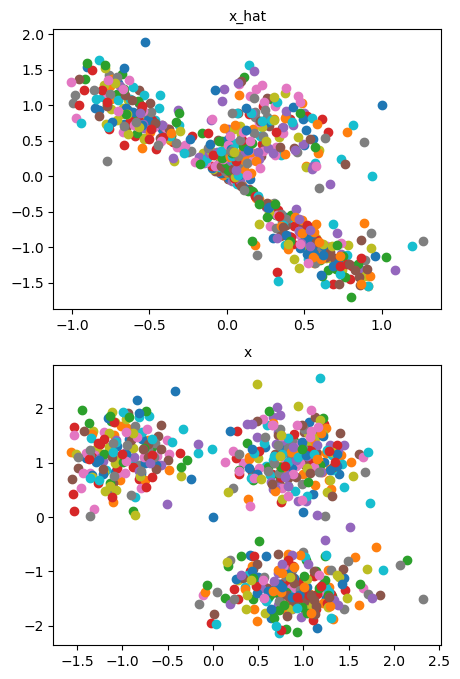

[[ 0.6483521 -0.5291846]]


: 

In [12]:
import numpy as np
import time
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

dim = 2
figure, (ax1, ax2) = plt.subplots(2, 1, figsize=(5, 8))
# bc1 = ax1.bar(list(range(dim)), np.linspace(-2,2,dim))
# bc2 = ax2.bar(list(range(dim)), np.linspace(-2,2,dim))
bc1 = ax1.scatter(np.array([0.0, 1.0]), np.array([0.0, 1.0]))
bc2 = ax2.scatter(np.array([0.0, 1.0]), np.array([0.0, 0.1]))
# bc2 = ax2.matshow(model.theta[0].numpy(), cmap='seismic', vmin=-1.0, vmax=1.0)
ax1.set_title("x_hat", fontsize=10)
ax2.set_title("x", fontsize=10)


plt.ion()

for iter in range(1000):

    x, y = process.sample(n_s=1)
    # Ns = x.shape[0] + Ns * alpha

    # conduct iterative inference & update NGC system
    readouts, delta = model.settle(
                        clamped_vars=[("z0","z",x)],
                        readout_vars=[("mu0","phi(z)"),("mu1","phi(z)")]
                      )
    x_hat = readouts[0][2]

    # ToD = calc_ToD(model) + ToD * alpha # calc ToD
    # ToD_list.append((ToD/Ns))
    # x_iter.append(iter)
    # Lx = tf.reduce_sum( metric.mse(x_hat, x) ) + Lx * alpha
    #delta = model.calc_updates()
    for p in range(len(delta)):
        delta[p] = delta[p] * (1.0/(x.shape[0] * 1.0))
    opt.apply_gradients(zip(delta, model.theta))
    model.apply_constraints()
    print(readouts[0][2].numpy())
    ax1.scatter(readouts[0][2].numpy()[0][0], readouts[0][2].numpy()[0][1])
    ax2.scatter(x.numpy()[0][0], x.numpy()[0][1])
    # for d in range(dim):
    #     bc1[d].set_height((readouts[0][2].numpy()[0][d]))
    #     bc2[d].set_height((x.numpy()[0][d]))


    model.clear()
    clear_output(wait=True)
    figure.canvas.draw()
    display(figure)
    # time.sleep(0.1)